<img src = 'image/k-water_logo.png' alt = 'Drawing' style = 'width: 200px;'/>

<p style='font-size:30px; line-height:1em'>[Notebook] 광역 상수관망 누수 감지</p>

# 분석 개요

## 분석주제 및 목표

* 차압을 활용한 상수관망 관로누수 판별
  - 2016년 10월 11일 오전 8시경 발생한 충남중부권 광역상수도 누수 사고 식별 및 사고 발생 지점 파악

## 분석과정
분석환경 설정 > 데이터 가져오기 > 데이터 탐색 > 데이터 전처리 > 모델링

* 데이터 탐색: 시계열 그래프 작성을 통한 연도별 유량, 유압 데이터 탐색
* 데이터 전처리: 데이터 타입 변환
* 모델링: Linear Regression, Support Vector Machine

## 데이터 설명
* 데이터 유형: csv 파일
* 파일 크기: 관측치 3682개(행), 변수 11개(열), 265KB
* 데이터 수집: 수자원공사에서 2016년 10월 11일 0시 ~ 10시 및 2017년 5월 1일 ~ 9월 6일 동안 수집
* 데이터 내용: 2016년 충남중부권 상수도 사고 데이터 및 2017년 충남중부권 상수도 센서 데이터
* 비고  
    - 변수명으로 사용한 약자는 아래와 같이 데이터 관측 지점을 나타냄. 
        - CB: 중부분기  
        - JG: 장기  
        - KJ: 공주(정수장)  
        - OR: 옥룡(정수장)  
        - KR: 계룡  
        - NSB: 노성분기
        - SS: 석성(정수장)  
    - 데이터 관측지점은 총 3개 구간으로 나눌 수 있음.
        - 1구간: 중부분기 ~ 장기
        - 2구간: 장기 ~ 계룡
        - 3구간: 계룡 ~ 석성
    - 물이 흐르는 방향: 현도 → 석성

<img src = 'image/충남중부권 관망도.bmp' alt = 'Drawing' style = 'width: 500px;'/>

## 변수 설명
총 변수 수: 11개  
* 시간 변수: DATE
* 종속 변수: CB_F, JG_F, SS_F  / (참고) 종속 변수명에 있는 'F'는 'Flow'를 뜻하며 해당 변수가 유량(Flow)임을 의미
* 독립 변수: CB_JG, JG_KJ, JG_OR, JG_KR, KR_NSB, KR_SS, NSB_SS / (참고) 독립 변수는 지점 간 유압 차(차압)를 의미함. 예를 들어, CB_JG는 중부분기와 장기 간 유압 차를 나타냄.

# 분석환경 설정

In [ ]:
# 작업 디렉토리 설정
setwd(paste0('/home/', Sys.getenv('USER') ,'/recipe01'))

# 작업 디렉토리 확인
getwd()

## 패키지 불러오기

* kernlab: ksvm()  
* neuralnet: neuralnet()
* dplyr: arrange(), select(), filter(), 파이프 연산자(%>%)
* lubridate: ymd(), hours()
* ModelMetrics: rmse()
* ggplot2: ggplot()
* scales : date_format()

In [2]:
# warning 메세지를 보여주지 않음
options(warn = -1)

# 패키지 불러오기
suppressPackageStartupMessages({
    library(kernlab) 
    library(neuralnet)
    library(dplyr)
    library(lubridate)
    library(ModelMetrics)
    library(ggplot2)
    library(scales)
})

## 사용자 함수 불러오기

* ts_graph_fn: ggplot을 이용한 시계열 그래프

In [3]:
# 사용자 함수 불러오기

# ts_graph_fn: ggplot을 이용한 시계열 그래프
source('src/R_function.r')

# 데이터 가져오기

In [4]:
# 데이터 가져오기(csv 파일)
data_df <- read.csv('input/kwater_recipe01_dataset.csv')

In [5]:
# 데이터 구조 파악하기

# str(): 데이터 구조, 변수 개수, 변수명, 데이터 유형 등을 미리보는 함수
str(data_df)

'data.frame':	3682 obs. of  11 variables:
 $ DATE  : chr  "2016-10-11 0:00" "2016-10-11 0:01" "2016-10-11 0:02" "2016-10-11 0:03" ...
 $ CB_F  : int  4003 4006 4025 4031 4000 4006 4014 4008 3994 4011 ...
 $ CB_JG : num  -2.93 -2.67 -3.09 -2.69 -3.02 ...
 $ JG_F  : int  4005 4000 4011 4024 4014 4012 4003 4000 3996 4004 ...
 $ JG_KJ : num  8.62 8.62 8.61 8.62 8.61 ...
 $ JG_OR : num  4.73 4.73 4.73 4.74 4.73 ...
 $ JG_KR : num  6.89 6.89 6.88 6.89 6.89 ...
 $ SS_F  : int  2449 2449 2444 2448 2451 2450 2451 2454 2450 2445 ...
 $ KR_NSB: num  -2.62 -2.62 -2.58 -2.62 -2.63 ...
 $ KR_SS : num  1.37 1.37 1.36 1.38 1.37 ...
 $ NSB_SS: num  3.99 3.99 3.94 4 4 ...


3682개 행, 11개 열로 구성된 데이터입니다.  

In [6]:
# 데이터 가공하기

# 날짜형 변수로 변환
data_df$DATE <- lubridate::ymd_hm(data_df$DATE)

# DATE 변수를 오름차순으로 정렬
data_df <- data_df %>% arrange(DATE)

변수 DATE가 문자형이므로 lubridate 패키지의 ymd_hm() 함수를 사용하여 날짜형으로 변환합니다.  
as.Date() 함수가 아닌 ymd_hm() 함수를 사용하는 이유는 변수 DATE가 '2016-10-11 00:01'처럼 분 단위까지 기록된 변수이기 때문입니다. 만약 DATE 변수에 as.Date() 함수를 사용하여 날짜형으로 변환하면 시간 단위의 값은 사라지고 '2016-10-11'과 같이 날짜만 남게 됩니다.

In [7]:
# 데이터 확인하기

# 가공된 데이터 구조 확인
str(data_df)
head(data_df, n = 10)

'data.frame':	3682 obs. of  11 variables:
 $ DATE  : POSIXct, format: "2016-10-11 00:00:00" "2016-10-11 00:01:00" ...
 $ CB_F  : int  4003 4006 4025 4031 4000 4006 4014 4008 3994 4011 ...
 $ CB_JG : num  -2.93 -2.67 -3.09 -2.69 -3.02 ...
 $ JG_F  : int  4005 4000 4011 4024 4014 4012 4003 4000 3996 4004 ...
 $ JG_KJ : num  8.62 8.62 8.61 8.62 8.61 ...
 $ JG_OR : num  4.73 4.73 4.73 4.74 4.73 ...
 $ JG_KR : num  6.89 6.89 6.88 6.89 6.89 ...
 $ SS_F  : int  2449 2449 2444 2448 2451 2450 2451 2454 2450 2445 ...
 $ KR_NSB: num  -2.62 -2.62 -2.58 -2.62 -2.63 ...
 $ KR_SS : num  1.37 1.37 1.36 1.38 1.37 ...
 $ NSB_SS: num  3.99 3.99 3.94 4 4 ...


,DATE,CB_F,CB_JG,JG_F,JG_KJ,JG_OR,JG_KR,SS_F,KR_NSB,KR_SS,NSB_SS
,<dttm>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,2016-10-11 00:00:00,4003,-2.9288,4005,8.615,4.7325,6.8875,2449,-2.625,1.3675,3.9925
2,2016-10-11 00:01:00,4006,-2.6688,4000,8.618,4.7325,6.8900,2449,-2.625,1.3675,3.9925
3,2016-10-11 00:02:00,4025,-3.0900,4011,8.610,4.7300,6.8850,2444,-2.583,1.3625,3.9450
4,2016-10-11 00:03:00,4031,-2.6888,4024,8.618,4.7350,6.8875,2448,-2.625,1.3750,4.0000
5,2016-10-11 00:04:00,4000,-3.0213,4014,8.610,4.7275,6.8875,2451,-2.635,1.3700,4.0050
6,2016-10-11 00:05:00,4006,-3.0438,4012,8.618,4.7325,6.8875,2450,-2.633,1.3775,4.0100
7,2016-10-11 00:06:00,4014,-3.0750,4003,8.618,4.7325,6.8900,2451,-2.625,1.3675,3.9925
8,2016-10-11 00:07:00,4008,-3.1500,4000,8.618,4.7325,6.8875,2454,-2.625,1.3750,4.0000
9,2016-10-11 00:08:00,3994,-3.2163,3996,8.615,4.7350,6.8950,2450,-2.625,1.3750,4.0000


변수 DATE가 POSIXct 클래스로 바뀐 것을 확인 할 수 있습니다.  
(참고) POSIXct 클래스는 시간을 초 단위의 정수로 기록하는 클래스입니다.

# 데이터 탐색

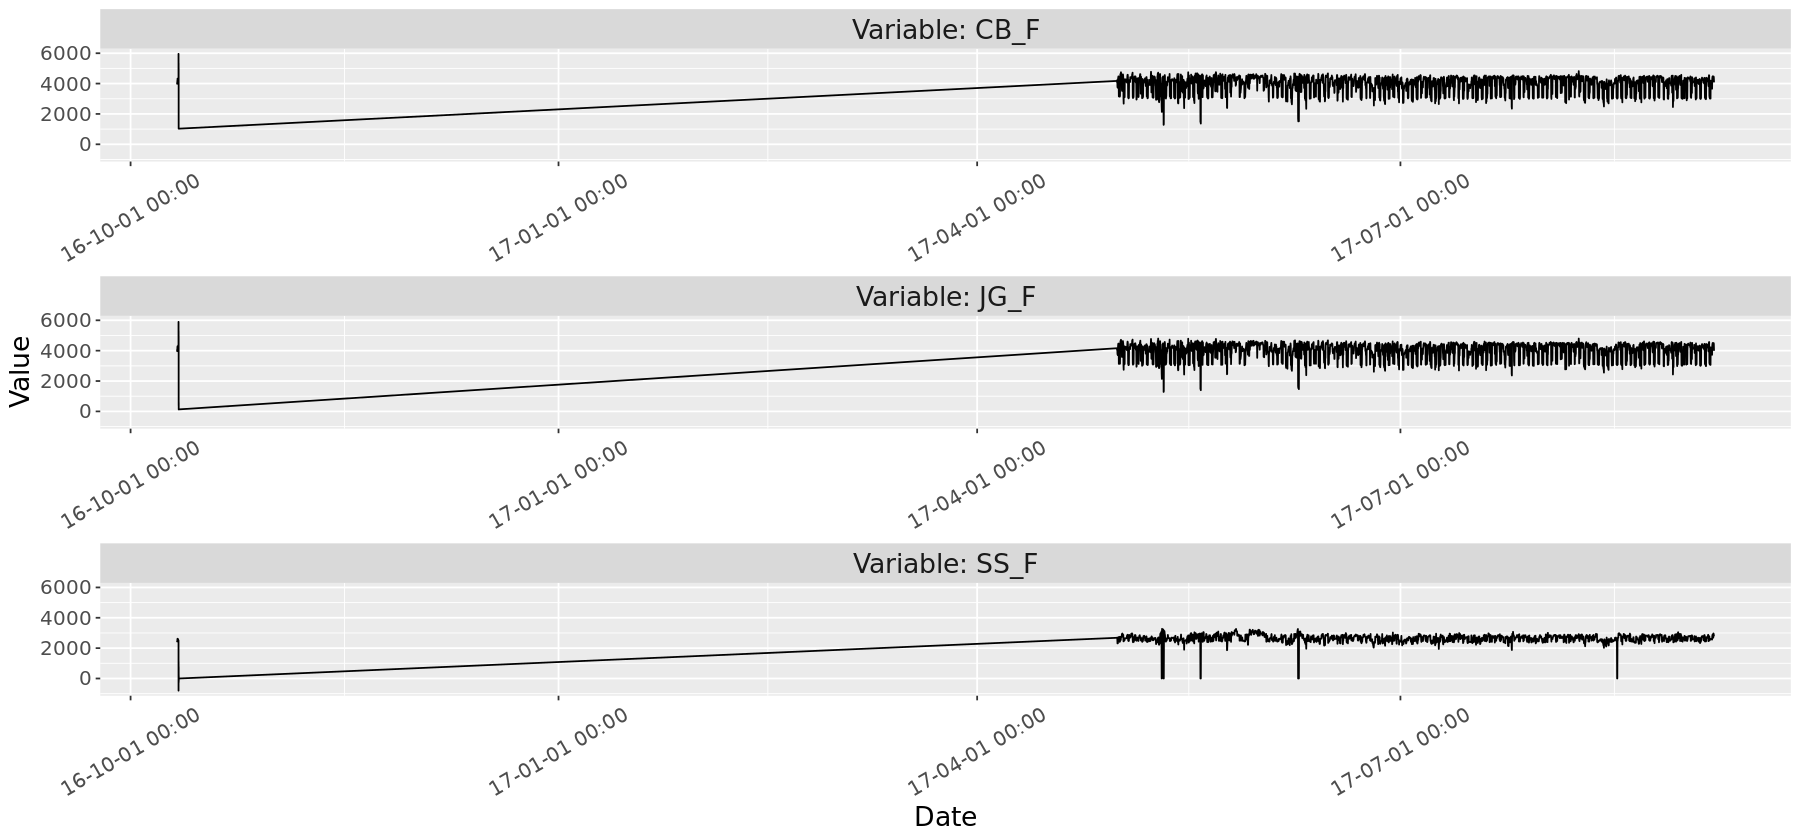

In [8]:
# 유량 데이터(종속변수) 살펴보기

# options(): 그래프 옵션 함수
# 입력값: repr.plot.width(그래프 너비), repr.plot.height(그래프 높이)
options(repr.plot.width = 15, repr.plot.height = 7)

# 사용자함수 ts_graph_fn(): ggplot을 이용한 시계열 그래프 작성
# 입력값: input_df(그래프 작성을 위한 데이터), input.scales(축 범위 '고정'('free_x') 혹은 '고정하지 않음'('free')을 의미)
ts_graph_fn(input_df = data_df %>% select(DATE, ends_with('_F')), input.var = 'DATE', input.scales = 'free_x', nrow = 3)

그래프의 X축을 보면 데이터가 수집된 기간이 2016년~2017년임을 알 수 있습니다. 그래프의 선을 보면 2016년에서 2017년으로 이어져 변수의 패턴을 보입니다. 이는 2016년에 수집한 데이터와 2017년도에 수집한 데이터 사이에 시간 공백이 있음을 보여줍니다. 그리고 2016년에 그래프 선이 수직으로 그려진 모습은 2017년에 데이터를 수집한 기간에 비해 2016년에 수집한 기간이 매우 짧아 그 모습이 제대로 표현이 안된 것이라고 할 수 있습니다.

석성(SS) 지점의 측정값이 중부분기(CB), 장기(JG)에 비해 낮은 것을 알 수 있습니다. 이는 관측지점인 중부분기와 장기 사이에는 물을 끌어다 쓰는 곳이 없는 반면, 장기와 석성 사이에는 공주 정수장, 옥룡 정수장 등에서 물을 일부 가져다 쓰기 때문입니다. 그렇기 때문에 중부분기와 장기 지점은 유량이 유사한 패턴을 보이나 석성은 중부분기, 장기와 다른 패턴을 보입니다.

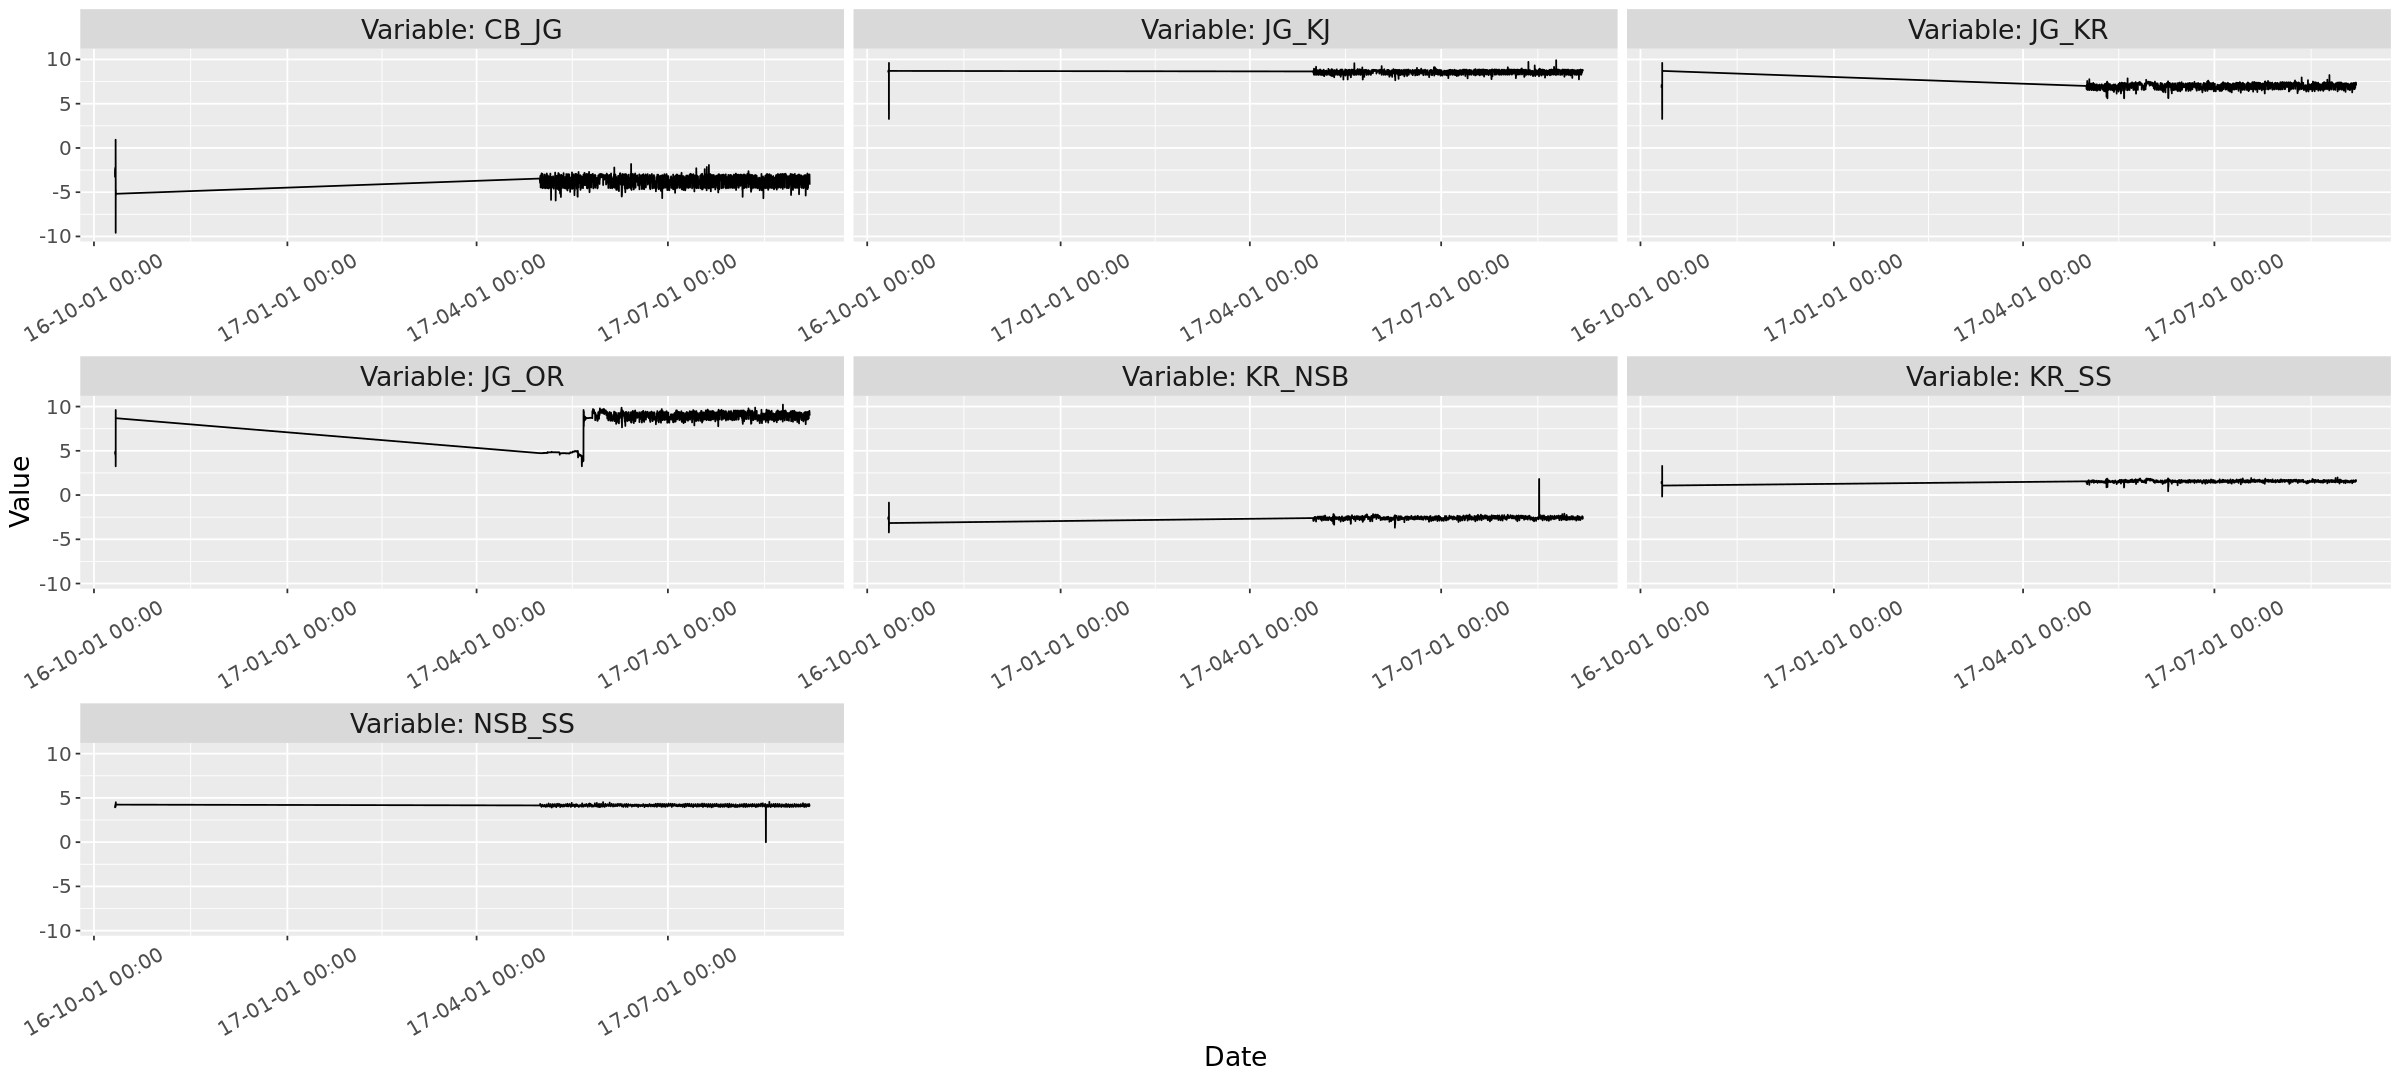

In [9]:
# 차압 데이터(독립변수) 살펴보기
options(repr.plot.width = 20, repr.plot.height = 9)
ts_graph_fn(input_df = data_df %>% select(DATE, !ends_with('_F')), input.var = 'DATE', input.scales = 'free_x')

앞서 그린 유량 데이터의 그래프와 같이 지점 간 차압 데이터는 2016년과 2017년 사이에 공백인 기간을 가집니다.  
유량 데이터와 지점 간 차압 데이터를 시간에 따른 선 그래프로 그려 모습을 확인하니, 데이터를 연도를 기준으로 구분해 살펴볼 필요가 있습니다.

# 데이터 전처리

## 데이터 분할

이번 과제는 2016년 발생한 충청남도 공주시 부근 누수 사고 식별이 목표입니다.  
따라서 변수 DATE를 기준으로 2017년 데이터는 train, 2016년 데이터는 test dataset으로 분할하여 생성합니다.  
  
    - train_df: 3081개 행(2017년 5월 1일 1시 ~ 2017년 9월 6일 10시, 1시간 단위)  
    - test_df: 601개 행(2016년 10월 11일 0시 0분 ~ 2016년 10월 11일 10시 0분, 1분 단위)

In [10]:
# train, test dataset 분할
train_df <- data_df %>% filter(lubridate::year(DATE) == 2017)  # 3081 obs.
test_df <- data_df %>% filter(lubridate::year(DATE) == 2016)  # 601 obs.

In [11]:
# train dataset 확인
summary(train_df)

      DATE                          CB_F          CB_JG             JG_F     
 Min.   :2017-05-01 01:00:00   Min.   :1281   Min.   :-5.939   Min.   :1282  
 1st Qu.:2017-06-02 03:00:00   1st Qu.:3668   1st Qu.:-3.969   1st Qu.:3701  
 Median :2017-07-04 05:00:00   Median :4150   Median :-3.456   Median :4171  
 Mean   :2017-07-04 05:03:06   Mean   :3958   Mean   :-3.624   Mean   :3981  
 3rd Qu.:2017-08-05 07:00:00   3rd Qu.:4391   3rd Qu.:-3.175   3rd Qu.:4410  
 Max.   :2017-09-06 10:00:00   Max.   :4821   Max.   :-1.815   Max.   :4801  
     JG_KJ           JG_OR            JG_KR            SS_F     
 Min.   :7.650   Min.   : 3.252   Min.   :5.610   Min.   :   0  
 1st Qu.:8.478   1st Qu.: 8.500   1st Qu.:6.840   1st Qu.:2484  
 Median :8.668   Median : 8.910   Median :7.053   Median :2664  
 Mean   :8.608   Mean   : 8.308   Mean   :7.014   Mean   :2639  
 3rd Qu.:8.775   3rd Qu.: 9.275   3rd Qu.:7.258   3rd Qu.:2798  
 Max.   :9.913   Max.   :10.220   Max.   :8.238   Max.   :3273  

In [12]:
# test dataset 확인
summary(test_df)

      DATE                          CB_F          CB_JG              JG_F     
 Min.   :2016-10-11 00:00:00   Min.   :1030   Min.   :-9.5887   Min.   : 125  
 1st Qu.:2016-10-11 02:30:00   1st Qu.:4008   1st Qu.:-3.1325   1st Qu.:4011  
 Median :2016-10-11 05:00:00   Median :4098   Median :-2.9587   Median :4095  
 Mean   :2016-10-11 05:00:00   Mean   :3599   Mean   :-3.2217   Mean   :3432  
 3rd Qu.:2016-10-11 07:30:00   3rd Qu.:4206   3rd Qu.:-2.7375   3rd Qu.:4215  
 Max.   :2016-10-11 10:00:00   Max.   :5957   Max.   : 0.9312   Max.   :5897  
     JG_KJ           JG_OR           JG_KR            SS_F     
 Min.   :3.275   Min.   :3.252   Min.   :3.275   Min.   :-800  
 1st Qu.:8.618   1st Qu.:4.730   1st Qu.:6.920   1st Qu.: 767  
 Median :8.655   Median :4.808   Median :6.990   Median :2455  
 Mean   :8.211   Mean   :5.397   Mean   :6.993   Mean   :1900  
 3rd Qu.:8.690   3rd Qu.:4.895   3rd Qu.:7.053   3rd Qu.:2584  
 Max.   :9.610   Max.   :9.610   Max.   :9.610   Max.   :2621  

### 유량 데이터

#### 2017년도

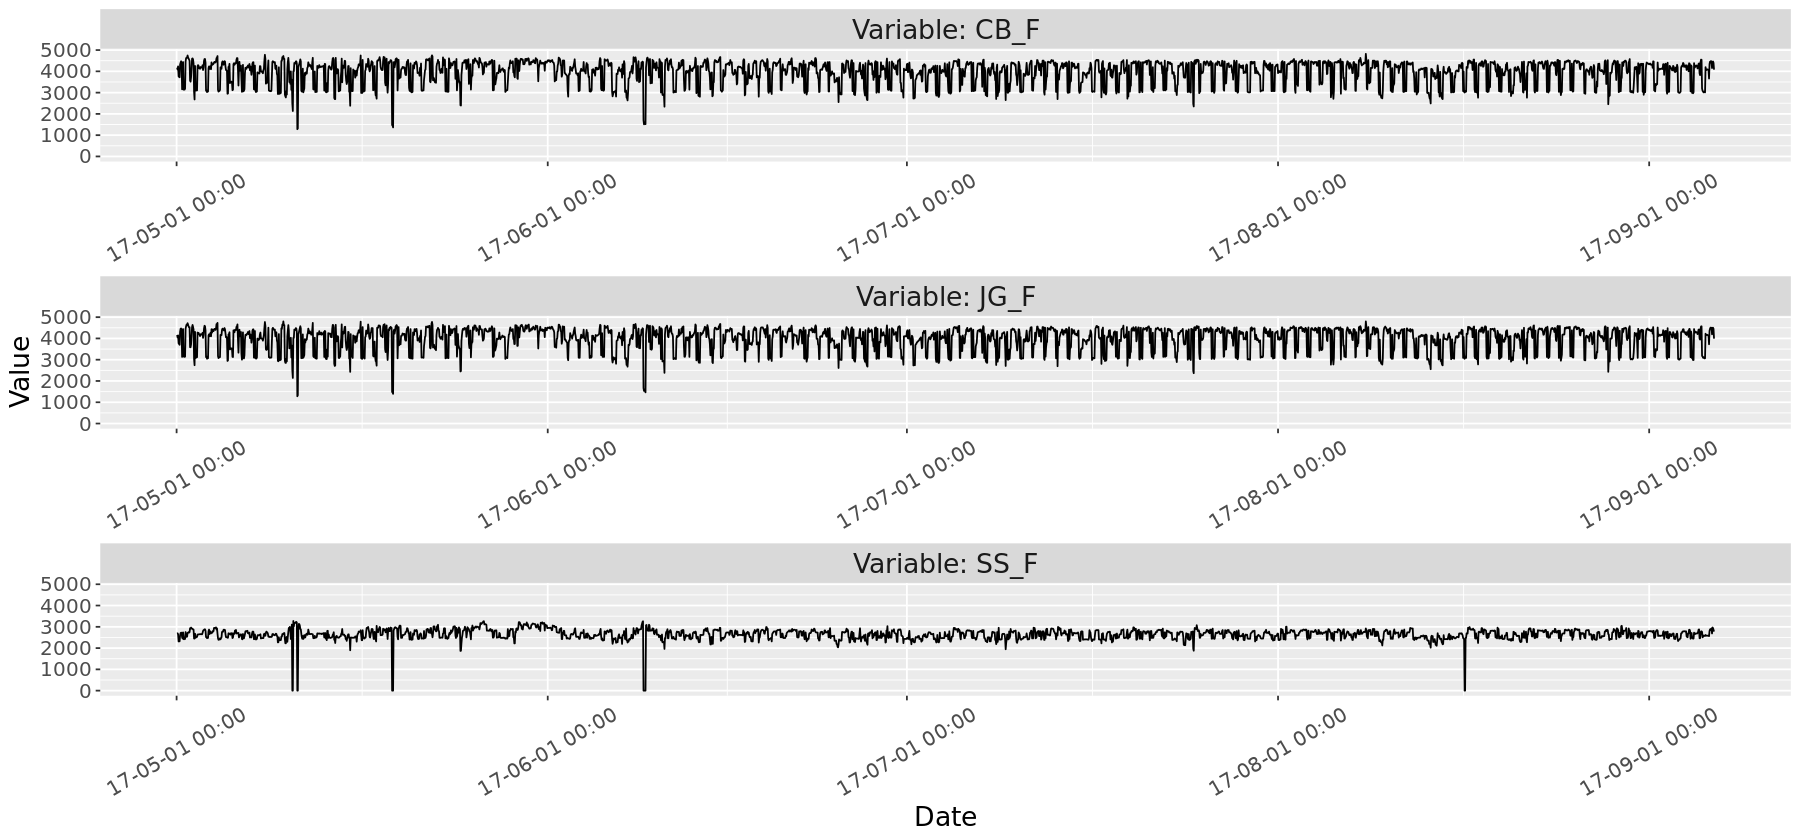

In [13]:
# 유량 데이터 시계열 그래프(train dataset)
options(repr.plot.width = 15, repr.plot.height = 7)
ts_graph_fn(input_df = train_df %>% select(DATE, ends_with('_F')), input.var = 'DATE', input.scales = 'free_x', nrow = 3)

train dataset으로 사용하는 2017년도 유량 데이터를 시계열 그래프로 시각화한 결과입니다.  
석성(SS) 지점의 측정값이 중부분기(CB), 장기(JG)에 비해 낮은 것을 알 수 있습니다.

#### 2016년도

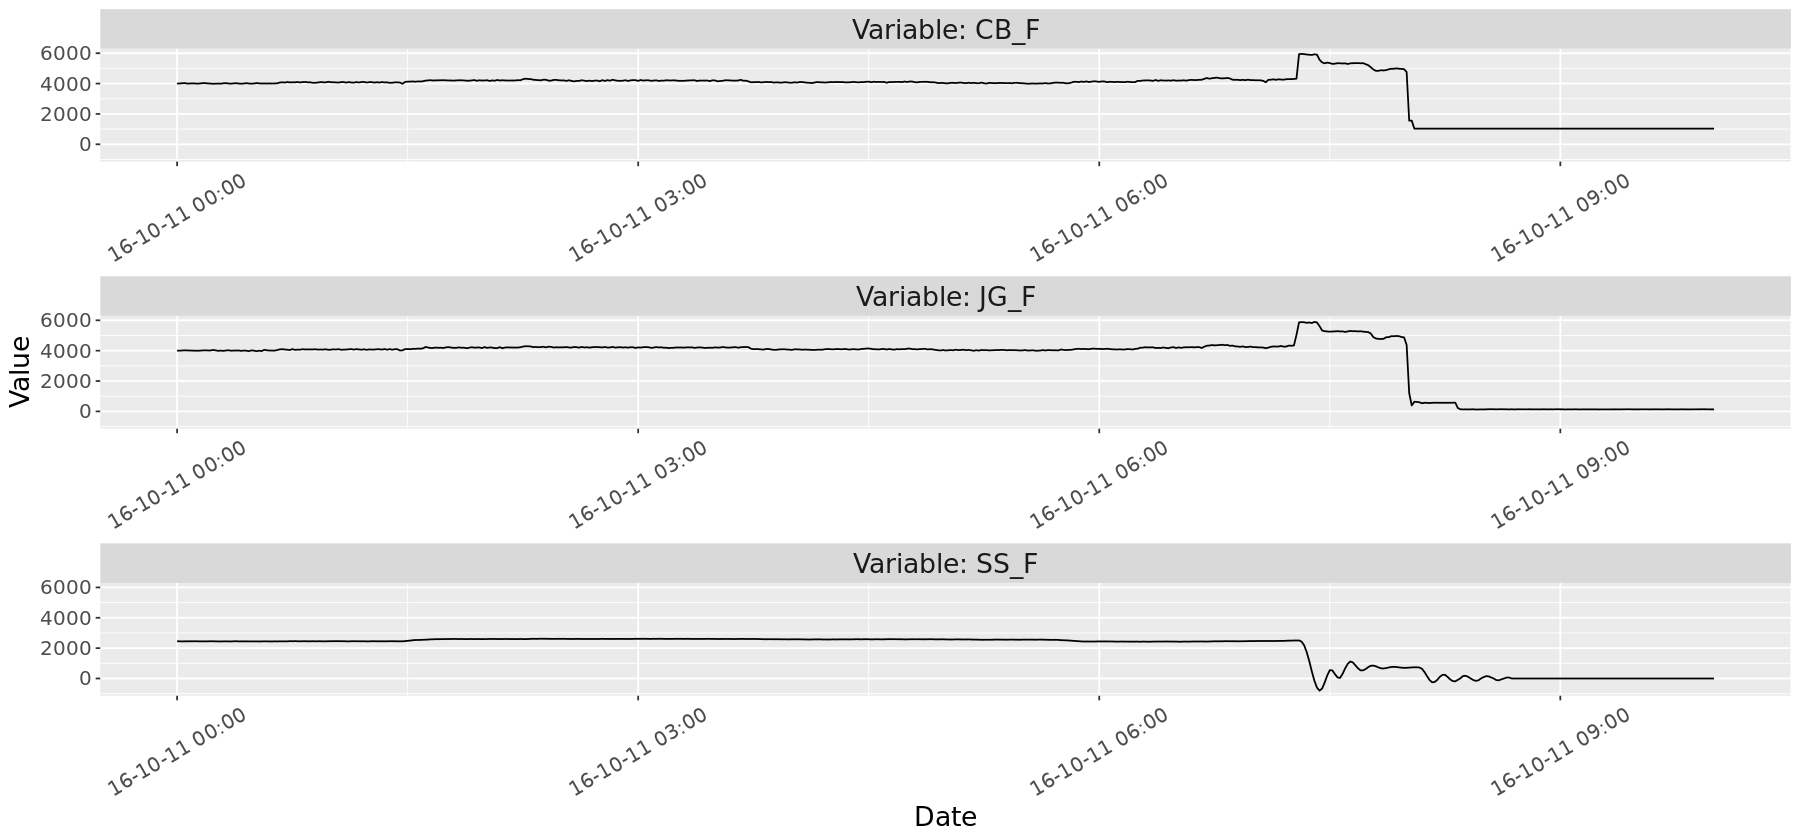

In [14]:
# 유량 데이터 시계열 그래프(test dataset)
options(repr.plot.width = 15, repr.plot.height = 7)
ts_graph_fn(input_df = test_df %>% select(DATE, ends_with('_F')), input.var = 'DATE', input.scales = 'free_x', nrow = 3)

test dataset으로 사용하는 2016년도 유량 데이터를 시계열 그래프로 시각화한 결과입니다.  
관로 파손 등으로 누수 사고가 발생하면 유량은 급격히 증거하거나 감소합니다. 오전 8시경 2구간에 속하는 공주(KG)와 옥룡(OR) 사이의 상수관에서 누수 시고가 발생했고, 이로 인해 1구간과 2구간의 유량 측정값이 증가하는 모습을 확인할 수 있습니다.  
석성에서 관측한 유량인 SS_F가 CB_F, JG_F와 다른 패턴을 보이는 이유는 앞서 2017년도에서 설명한 것과 같이 장기와 석성 사이에 있는 정수장에서 물을 일부 가져다 쓰기 때문입니다.

### 압력 데이터

#### 2017년도

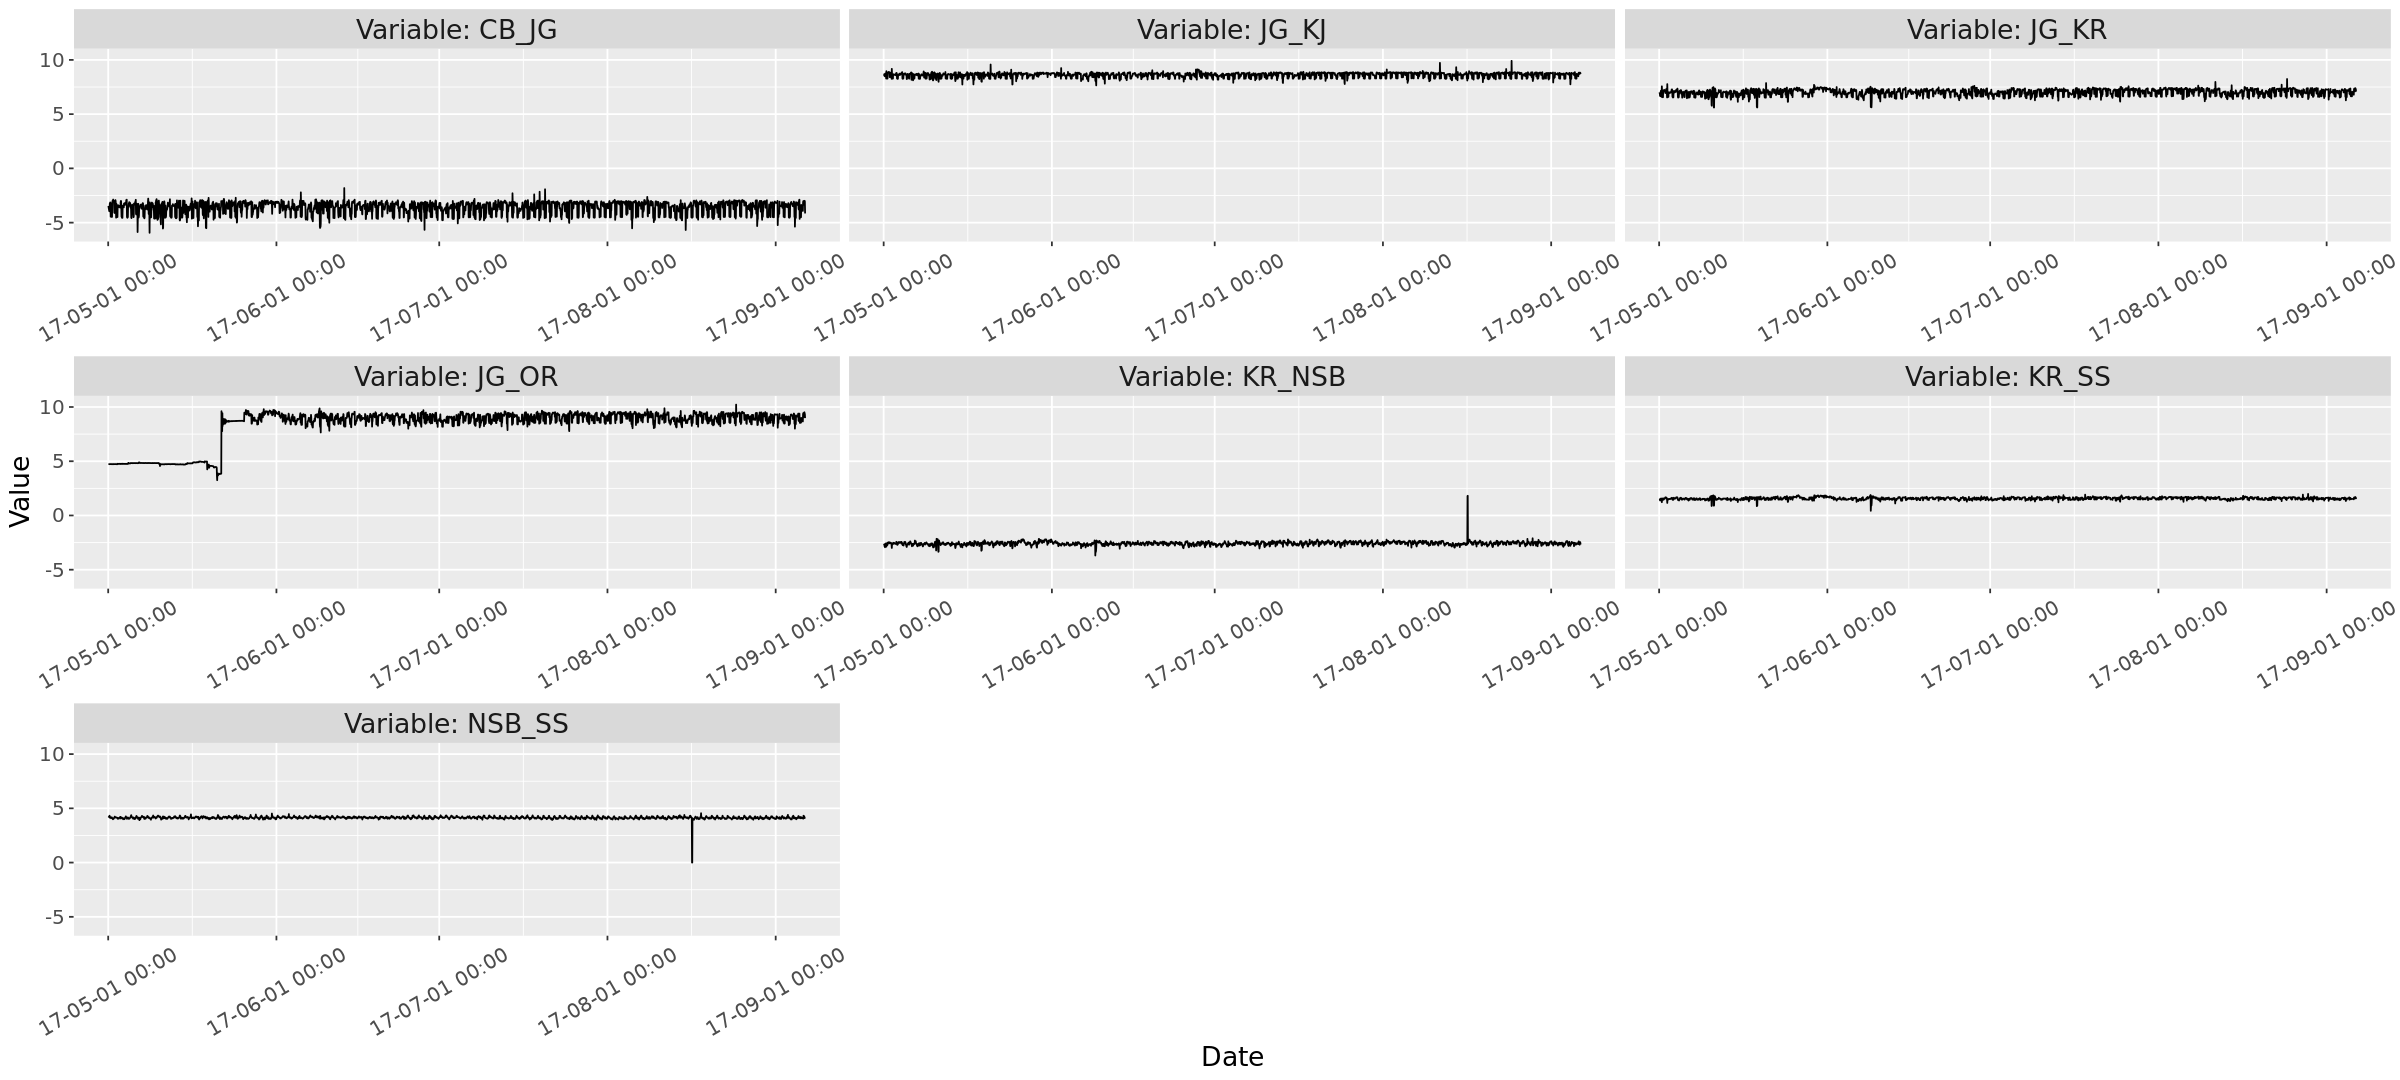

In [15]:
# 차압 데이터 시계열 그래프(train dataset)
options(repr.plot.width = 20, repr.plot.height = 9)
ts_graph_fn(input_df = train_df %>% select(DATE, !ends_with('_F')), input.var = 'DATE', input.scales = 'free_x')

train dataset으로 사용하는 2017년도 지점 간 유압 차(차압) 데이터를 시계열 그래프로 시각화한 결과입니다.  

#### 2016년도

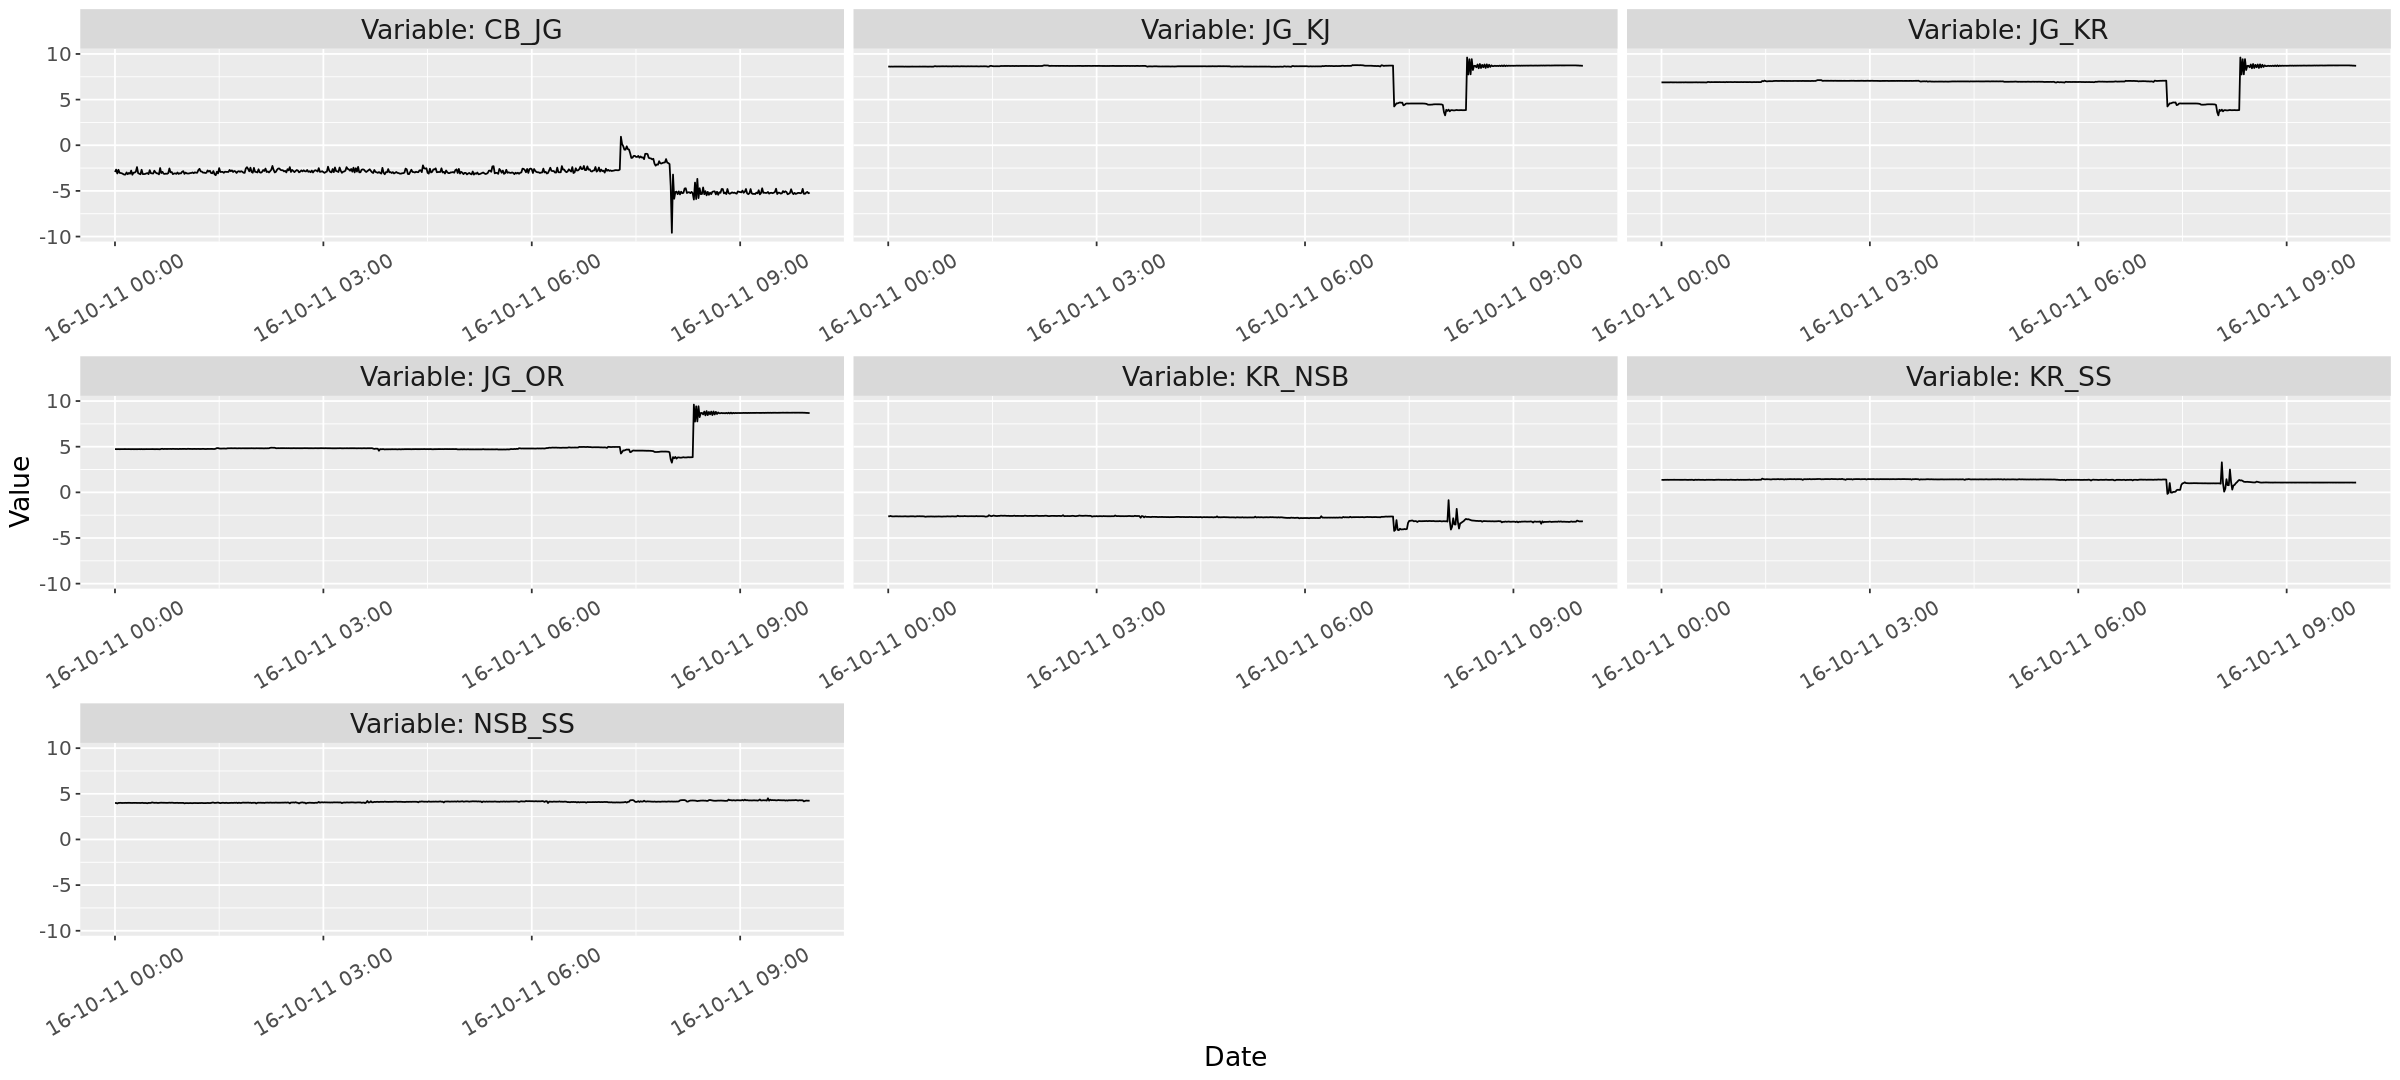

In [16]:
# 차압 데이터 시계열 그래프(test dataset)
options(repr.plot.width = 20, repr.plot.height = 9)
ts_graph_fn(input_df = test_df %>% select(DATE, !ends_with('_F')), input.var = 'DATE', input.scales = 'free_x')

test dataset으로 사용하는 2016년도 지점 간 유압 차(차압) 데이터를 시계열 그래프로 시각화한 결과입니다.   
누수 사고가 발생한 오전 8시 부근 전후로 CB_JG(중부분기와 장기 지점 간의 차압), JG_KJ(장기와 공주 지점 간의 차압) 등 차압 데이터의 값이 변화하는 모습을 확인할 수 있습니다.

## train, test dataset 비교

모델은 train dataset을 기준으로 데이터의 특성을 파악하기 때문에, train dataset과 test dataset의 분포가 다르면 모델의 예측 성능이 떨어질 수 있습니다.  
따라서 train, test dataset의 분포를 그래프로 확인하고 train, test dataset이 잘 구성되었는지 확인합니다.  

In [17]:
# train, test dataset 분포 비교
total_df <- rbind(mutate(train_df, group = 'train'), mutate(test_df, group = 'test'))

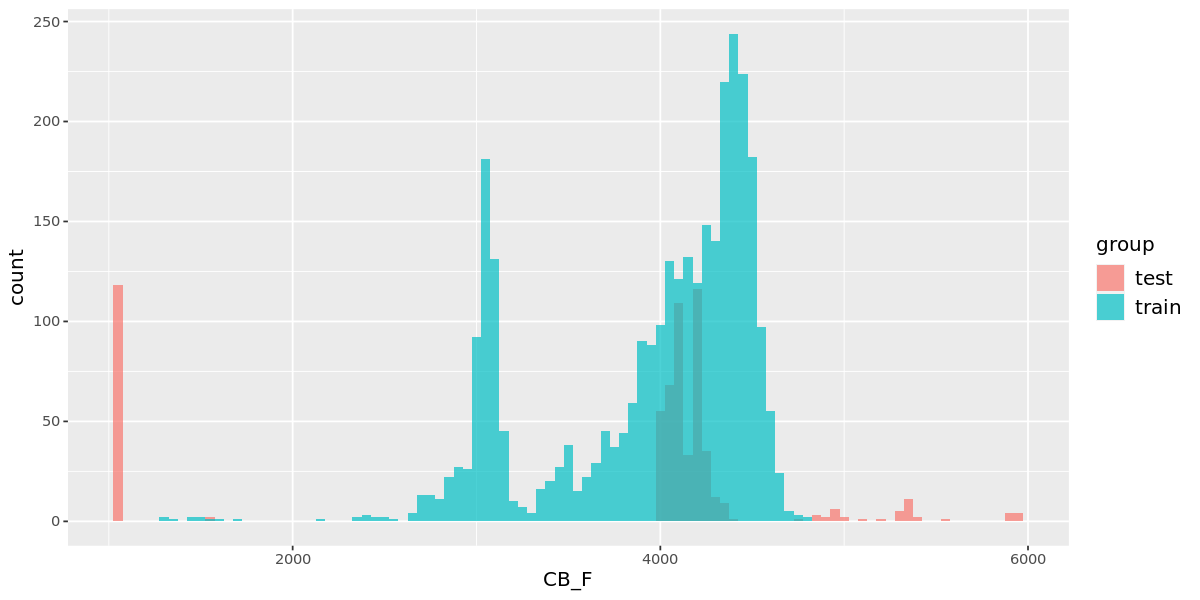

In [18]:
# 종속변수(CB_F)
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(total_df, aes(x = CB_F, fill = group)) + geom_histogram(alpha = 0.7, binwidth = 50,  position = 'identity') +
  theme(legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.title = element_text(size = 12))

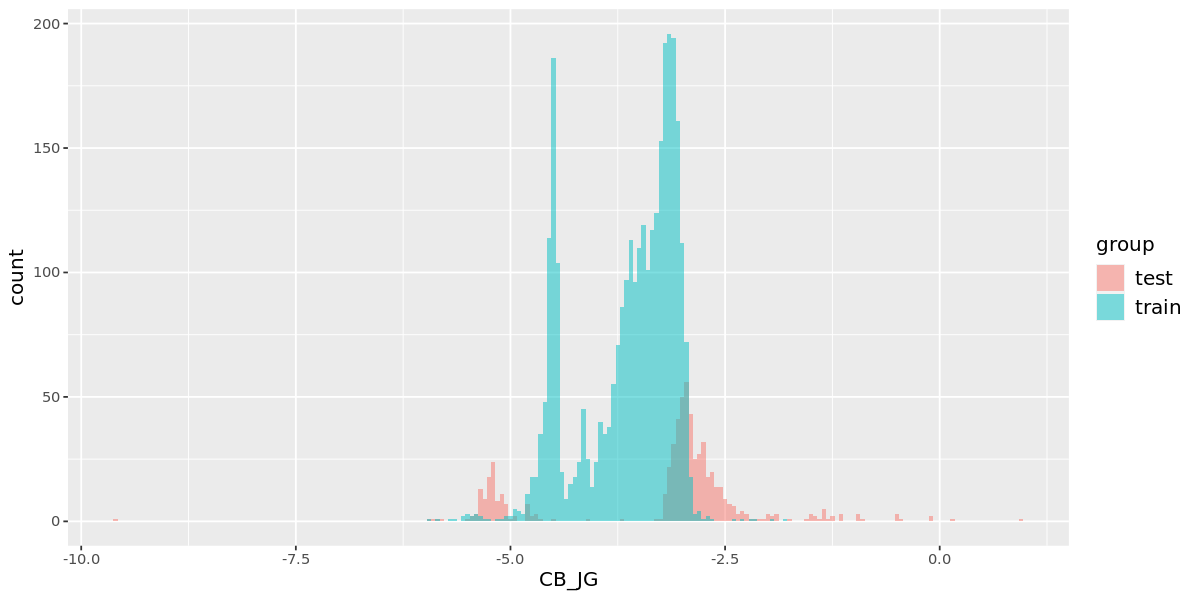

In [19]:
# 독립변수(CB_JG)
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(total_df, aes(x = CB_JG, fill = group)) + geom_histogram(alpha = 0.5, binwidth = 0.05,  position = 'identity') +
  theme(legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.title = element_text(size = 12))

# 모델 학습

1구간의 중부 분기에서 측정한 유량을 예측하고자 합니다. 중부 분기 지점에서 측정한 유량(CB_F)을 종속변수로, 중부 분기와 장기 측정 지점간의 유압 차(CB_JG)를 독립변수로 사용합니다.  
이번 과제에서는 선형회귀, 선형 서포트 벡터 머신, 비선형 서포트 벡터 머신 총 3가지 모형을 활용합니다.

모형이 잘 훈련되었는지 확인하기 위해 test dataset으로 평가하기 전, 모형을 학습한 train dataset을 사용하여 예측 및 평가를 진행합니다. 만약 train dataset으로도 예측 결과가 좋지 않다면 분석 모형을 다시 검토해야합니다.

In [20]:
# 분석 결과 재생성을 위해 seed 고정
set.seed(1234)

In [21]:
# 종속변수/독립변수 설정
y.var <- 'CB_F'
x.var <- c('CB_JG')

# 설정한 종립변수/독립변수를 기준으로 데이터셋 구성
train_y_df <- train_df %>% select(DATE, y.var)  # 종속변수 실제값
train_x_df <- train_df %>% select(DATE, x.var)  # predict() 함수는 newdata의 형식이 data.frame이어야 함

# 예측 모형 formula
formula.x <- paste(y.var, '~', paste(x.var, collapse = ' + '))

## 선형회귀

**[선형회귀(Linear Regression)]**
* 종속변수가 독립변수들에 의해 어떻게 설명되는지(인과관계)를 분석하는 통계적 기법
* 단순선형회귀분석은 독립변수가 한 개일 때 고려하는 회귀모형이며, 종속변수의 변화를 설명하기 위하여 두 개 이상의 독립변수를 고려하는 회귀모형을 다중회귀모형이라고 함.

In [22]:
# 선형회귀
model_lm <- lm(formula = as.formula(formula.x), data = train_df)
model_lm


Call:
lm(formula = as.formula(formula.x), data = train_df)

Coefficients:
(Intercept)        CB_JG  
     7337.6        932.6  


In [23]:
# 선형회귀를 통한 예측(train dataset)
pred_lm_result <- predict(model_lm, train_x_df, interval = 'prediction')

# 예측 평가지표(RMSE)
rmse.lm <- round(rmse(actual = train_y_df[, y.var], predicted = as.numeric(pred_lm_result[, 'fit'])), 2)
print(paste('RMSE of linear regression using train data is', round(rmse.lm, 2)))

[1] "RMSE of linear regression using train data is 187.42"


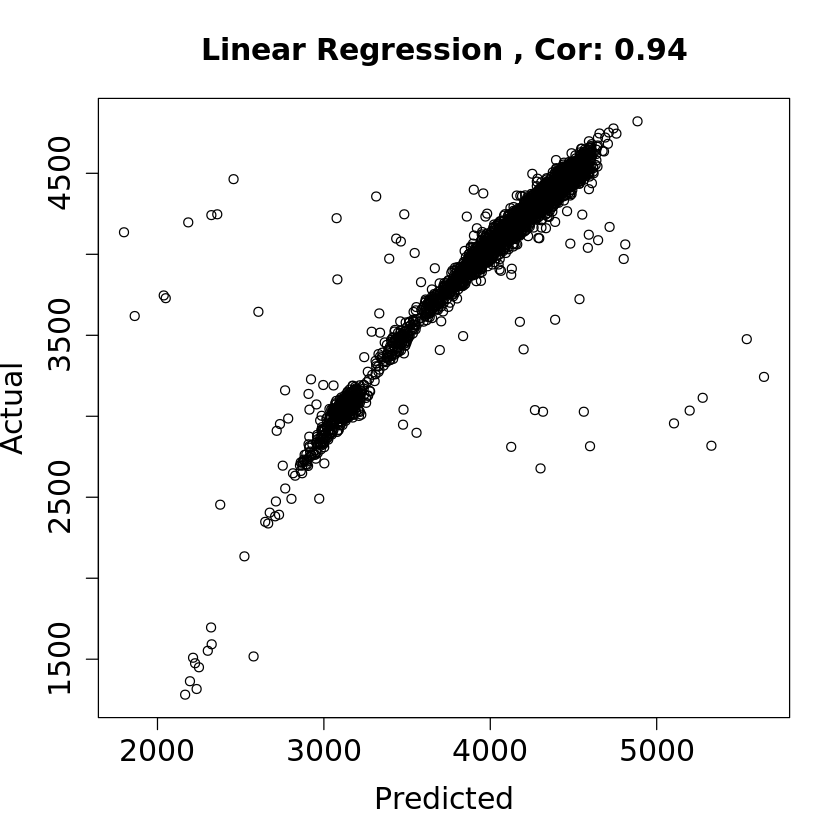

In [24]:
# 예측값과 실제값 비교(산점도)
options(repr.plot.width = 7, repr.plot.height = 7)
plot(x = pred_lm_result[, 'fit'], y = train_y_df[, y.var],
 xlab = 'Predicted', ylab = 'Actual',
 main = paste('Linear Regression', ', Cor:', round(cor(pred_lm_result[, 'fit'], train_y_df[, y.var]), 2)), cex.lab = 1.5, cex.main = 1.5, cex.axis = 1.5)

## SVM

**[SVM(Support Vector Machine)]**
* SVM(Support Vector Machine)은 마진(Margin)을 최대로 하는 경계면을 찾는 것이 목적인 방법론임.
* 마진은 각 범주에 속해있는 관측치 중 경계면과 가장 가까운 관측치와 경계면 사이의 거리를 의미함.
* 종속변수를 선형적으로 분리할 수 있는 경우 선형 SVM 알고리즘 사용하며 반대로 선형적으로 분리하기 힘든 경우 커널 트릭을 적용해서 비선형으로 분류하는 SVM 알고리즘 사용
* SVM 알고리즘을 활용하여 연속형 변수를 예측하는 모형을 서포트 벡터 회귀(Support Vector Regression)이라고 함.

### 선형 커널

* 아래 코드에서 사용한 'vanilladot'은 커널 트릭 없이 벡터의 내적만을 이용하는 방식임.
  - vanilladot: Linear kernel

In [25]:
# SVM 선형 커널
model_svm_linear <- ksvm(as.formula(formula.x), data = train_df, kernel = 'vanilladot')  # linear kernel 

 Setting default kernel parameters  


In [26]:
# 선형 서포트 벡터 머신을 통한 예측(train dataset)
pred_svm_linear_result <- predict(model_svm_linear, train_x_df)

# 예측 평가지표(RMSE)
rmse.svm.linear <- round(rmse(actual = train_y_df[, y.var], predicted = as.numeric(pred_svm_linear_result)), 2)
print(paste('RMSE of support vector regression with linear kernel using train data is', round(rmse.svm.linear, 2)))

[1] "RMSE of support vector regression with linear kernel using train data is 189.75"


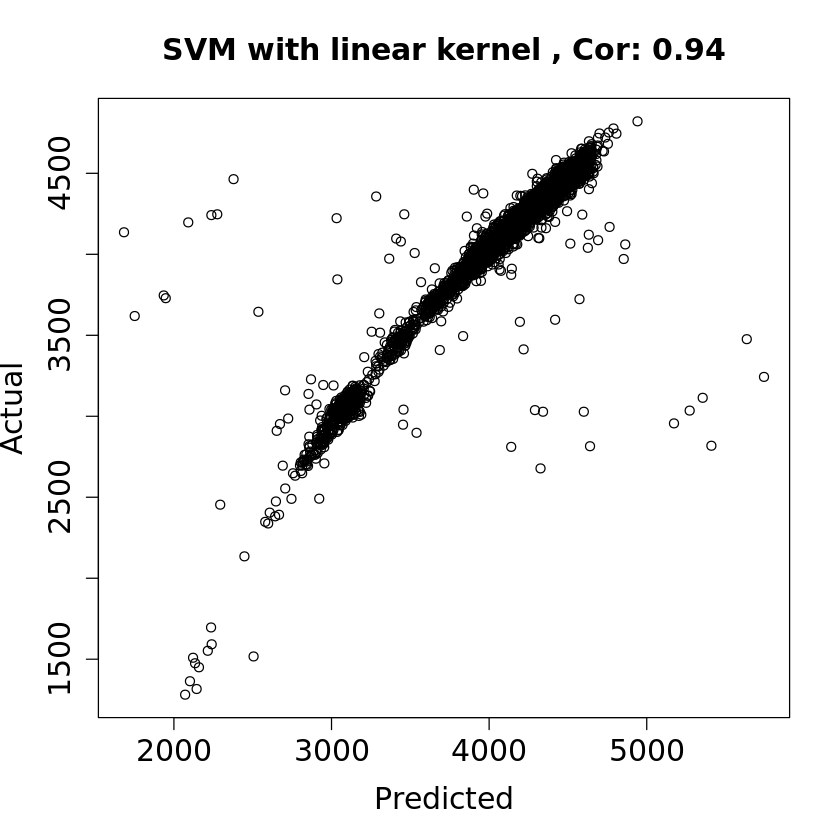

In [27]:
# 예측값과 실제값 비교(산점도)
plot(x = pred_svm_linear_result, y = train_y_df[, y.var],
 xlab = 'Predicted', ylab = 'Actual',
 main = paste('SVM with linear kernel', ', Cor:', round(cor(pred_svm_linear_result, train_y_df[, y.var]), 2)), cex.lab = 1.5, cex.main = 1.5, cex.axis = 1.5)

### 비선형 커널

* 비선형 데이터를 커널 트릭을 통해 선형적으로 분리 가능하도록 함.
  - 커널 트릭(kernel trick) : 커널 함수를 통해 데이터를 고차원 공간상으로 맵핑(mapping)
* 아래 코드에서 사용한 'rbfdot'은 커널 함수의 종류 중 하나인 가우시안 커널을 의미함.
  - rbfdot: Radial Basis kernel 'Gaussian'

In [28]:
# SVM 비선형 커널
model_svm_rbf <- ksvm(as.formula(formula.x), data = train_df, kernel = 'rbfdot')  # Radial Basis kernel 'Gaussian'

In [29]:
# 비선형 서포트 벡터 머신을 통한 예측(train dataset)
pred_svm_rbf_result <- predict(model_svm_rbf, train_x_df)

# 예측 평가지표(RMSE)
rmse.svm.rbf <- round(rmse(actual = train_y_df[, y.var], predicted = as.numeric(pred_svm_rbf_result)), 2)
print(paste('RMSE of support vector regression with non-linear kernel using train test is', round(rmse.svm.rbf, 2)))

[1] "RMSE of support vector regression with non-linear kernel using train test is 132.07"


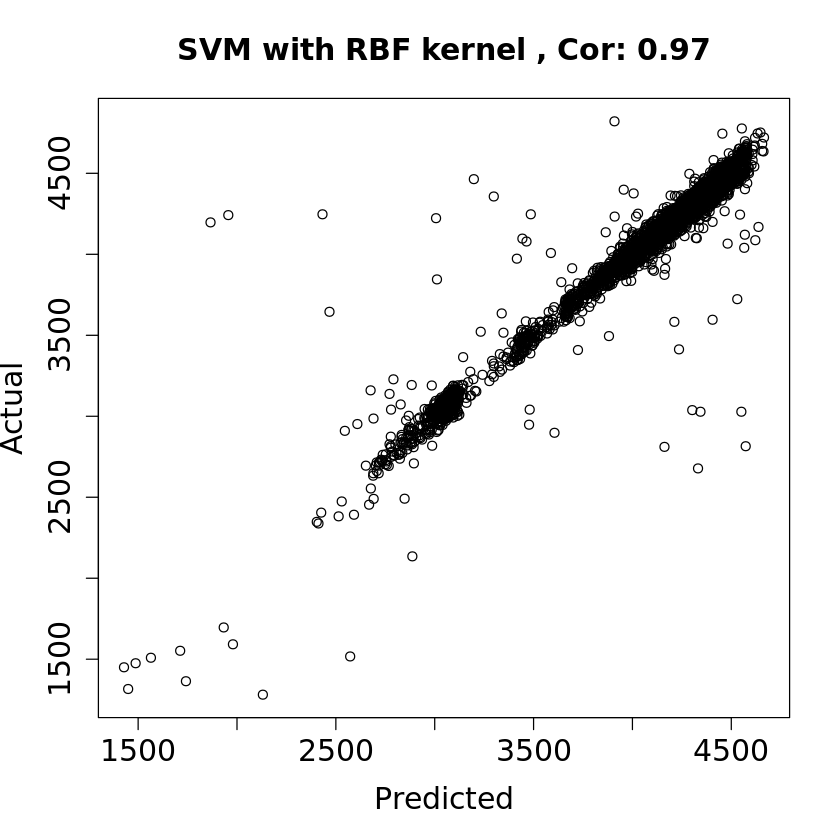

In [30]:
# 예측값과 실제값 비교(산점도)
plot(x = pred_svm_rbf_result, y = train_y_df[, y.var],
 xlab = 'Predicted', ylab = 'Actual',
 main = paste('SVM with RBF kernel', ', Cor:', round(cor(pred_svm_rbf_result, train_y_df[, y.var]), 2)), cex.lab = 1.5, cex.main = 1.5, cex.axis = 1.5)

In [31]:
# 모형 간 RMSE 비교
data.frame(lm = rmse.lm, 
           svm_linear = rmse.svm.linear, 
           svm_rbf = rmse.svm.rbf)

lm,svm_linear,svm_rbf
<dbl>,<dbl>,<dbl>
187.42,189.75,132.07


# 모델 평가

test dataset은 충남중부권 광역상수도 누수 데이터입니다. 이번 과제는 2016년 10월 11일 오전 8시 경 발생한 누수 사고를 식별하는 것이 목표입니다.  
앞서 train dataset으로 학습한 모형으로 test dataset을 사용하여 2016년도 중부 분기 지점의 유량을 예측합니다.

In [32]:
# 설정한 종립변수/독립변수를 기준으로 데이터셋 구성
test_y_df <- test_df %>% select(DATE, y.var)  # 종속변수 실제값
test_x_df <- test_df %>% select(DATE, x.var)  # pedict() 함수는 newdata의 형식이 data.frame이어야 함

## 선형회귀

In [33]:
# 선형회귀를 통한 예측(test dataset)
pred_lm_test_result <- predict(model_lm, test_x_df, interval = 'prediction')

# 예측 평가지표(RMSE)
rmse.test.lm <- round(rmse(actual = test_y_df[, y.var], predicted = as.numeric(pred_lm_test_result[, 'fit'])), 2)
print(paste('RMSE of linear regression using test data is', round(rmse.test.lm, 2)))

[1] "RMSE of linear regression using test data is 881.43"


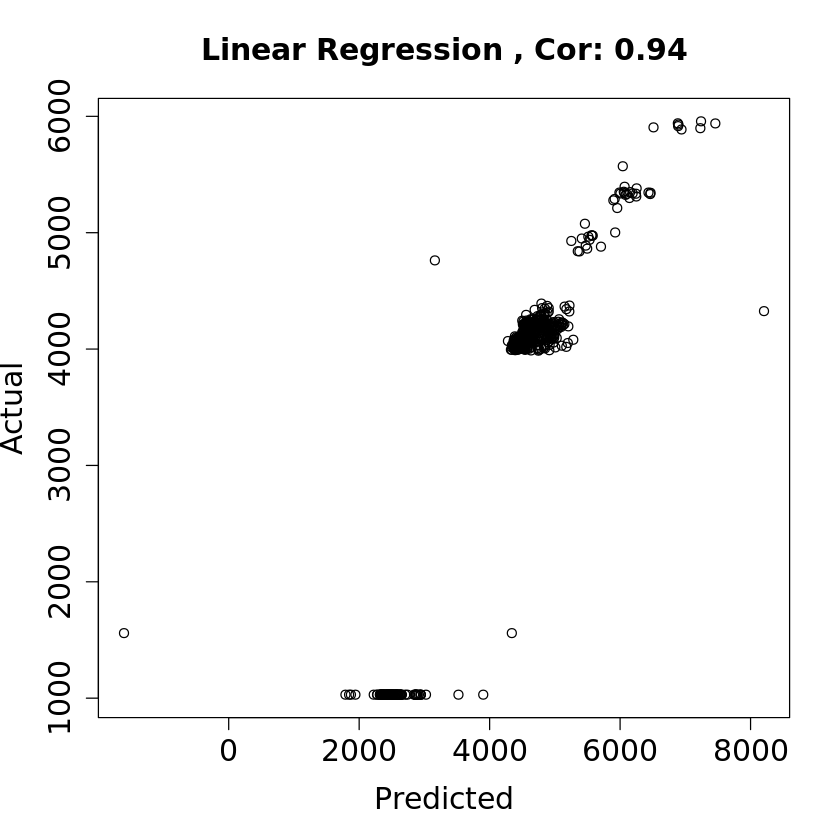

In [34]:
# 예측값과 실제값 비교(산점도)
options(repr.plot.width = 7, repr.plot.height = 7)
plot(x = pred_lm_test_result[, 'fit'], y = test_y_df[, y.var],
 xlab = 'Predicted', ylab = 'Actual',
 main = paste('Linear Regression', ', Cor:', round(cor(pred_lm_test_result[, 'fit'], test_y_df[, y.var]), 2)), cex.lab = 1.5, cex.main = 1.5, cex.axis = 1.5)

## SVM

### 선형 커널

In [35]:
# 선형 서포트 벡터 머신을 통한 예측(test dataset)
pred_svm_linear_test_result <- predict(model_svm_linear, test_x_df)

# 예측 평가지표(RMSE)
rmse.test.svm.linear <- round(rmse(actual = test_y_df[, y.var], predicted = as.numeric(pred_svm_linear_test_result)), 2)
print(paste('RMSE of support vector regression with linear kernel using test test is', round(rmse.test.svm.linear, 2)))

[1] "RMSE of support vector regression with linear kernel using test test is 892.22"


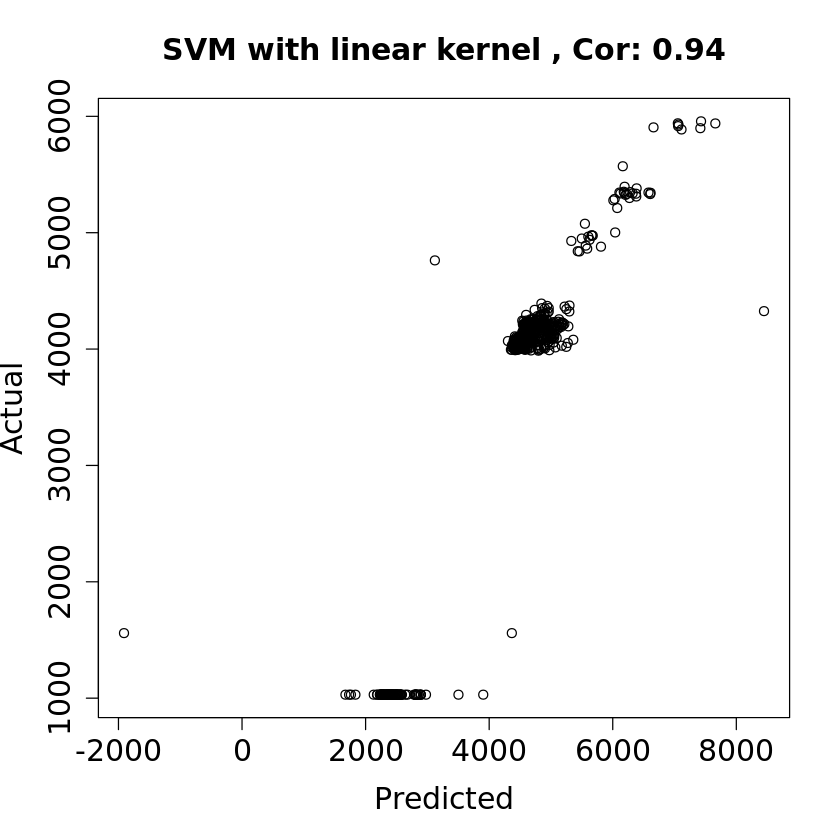

In [36]:
# 예측값과 실제값 비교(산점도)
plot(x = pred_svm_linear_test_result, y = test_y_df[, y.var],
 xlab = 'Predicted', ylab = 'Actual',
 main = paste('SVM with linear kernel', ', Cor:', round(cor(pred_svm_linear_test_result, test_y_df[, y.var]), 2)), cex.lab = 1.5, cex.main = 1.5, cex.axis = 1.5)

### 비선형 커널

In [37]:
# 비선형 서포트 벡터 머신을 통한 예측(test dataset)
pred_svm_rbf_test_result <- predict(model_svm_rbf, test_x_df)

# 예측 평가지표(RMSE)
rmse.test.svm.rbf <- round(rmse(actual = test_y_df[, y.var], predicted = as.numeric(pred_svm_rbf_test_result)), 2)
print(paste('RMSE of support vector regression with linear kernel using test test is', round(rmse.test.svm.rbf, 2)))

[1] "RMSE of support vector regression with linear kernel using test test is 1052.65"


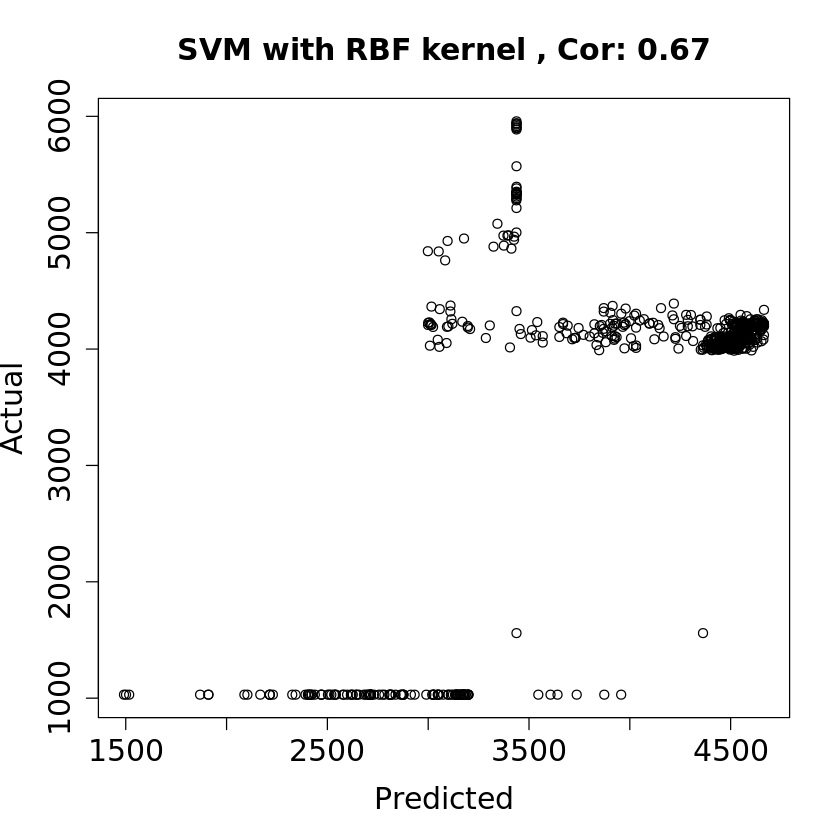

In [38]:
# 예측값과 실제값 비교(산점도)
plot(x = pred_svm_rbf_test_result, y = test_y_df[, y.var],
 xlab = 'Predicted', ylab = 'Actual',
 main = paste('SVM with RBF kernel', ', Cor:', round(cor(pred_svm_rbf_test_result, test_y_df[, y.var]), 2)), cex.lab = 1.5, cex.main = 1.5, cex.axis = 1.5)

## 모델 비교

연속형 종속변수에 대한 예측 모형은 오차를 활용하여 평가합니다.  
오차는 실제 데이터와와 예측 모형을 통해 계산된 예측값 간의 차이를 의미하며, 이 오차들을 비교하여 예측 모형의 적절성 판단 기준으로 활용합니다. 오차의 값이 낮을수록 예측 모형 성능이 우수하다고 판단합니다.  
오차를 활용한 예측평가지표로 ME(오차평균), MAE(절대평균오차), MSE(자승오차의 평균), SDE(오차의 표준편차), PE(오차의 백분율), MPE(오차백분율의 평균), MAPE(오차백분율 절대값의 평균), U(Theil의 U통계량), D-W statistic(Durbin-Waston의 통계량) 등이 있습니다.  
이번 과제에서는 **RMSE(오차제곱근의 평균)** 를 사용하며, RMSE가 가장 작은 모형이 다른 모형에 비해 예측 성능이 우수하다고 할 수 있습니다.

In [39]:
# 모형 간 RMSE 비교
data.frame(lm = rmse.test.lm, 
           svm_linear = rmse.test.svm.linear, 
           svm_rbf = rmse.test.svm.rbf)

lm,svm_linear,svm_rbf
<dbl>,<dbl>,<dbl>
881.43,892.22,1052.65


선형회귀모형의 RMSE가 가장 작으므로, 1구간의 중부분기 지점 유량을 예측할 때 선형회귀모형의 예측 성능이 다른 모형에 비해 좋다고 할 수 있습니다.

In [40]:
# 모델별 예측값 병합
result_df <- data.frame(DATE = test_df[, 'DATE'], ACTUAL = test_y_df[, y.var], LM = pred_lm_test_result[, 'fit'], 
                                    SVM_LINEAR = pred_svm_linear_test_result, SVM_RBF = pred_svm_rbf_test_result)

# csv 내보내기
write.csv(result_df, 'output/result of test in sector1.csv', row.names = FALSE)

실제값과 모델별 중부분기 유량 예측값을 하나의 데이터프레임으로 만들고, 만든 데이터프레임은 output 폴더에 csv 파일로 내보냅니다.

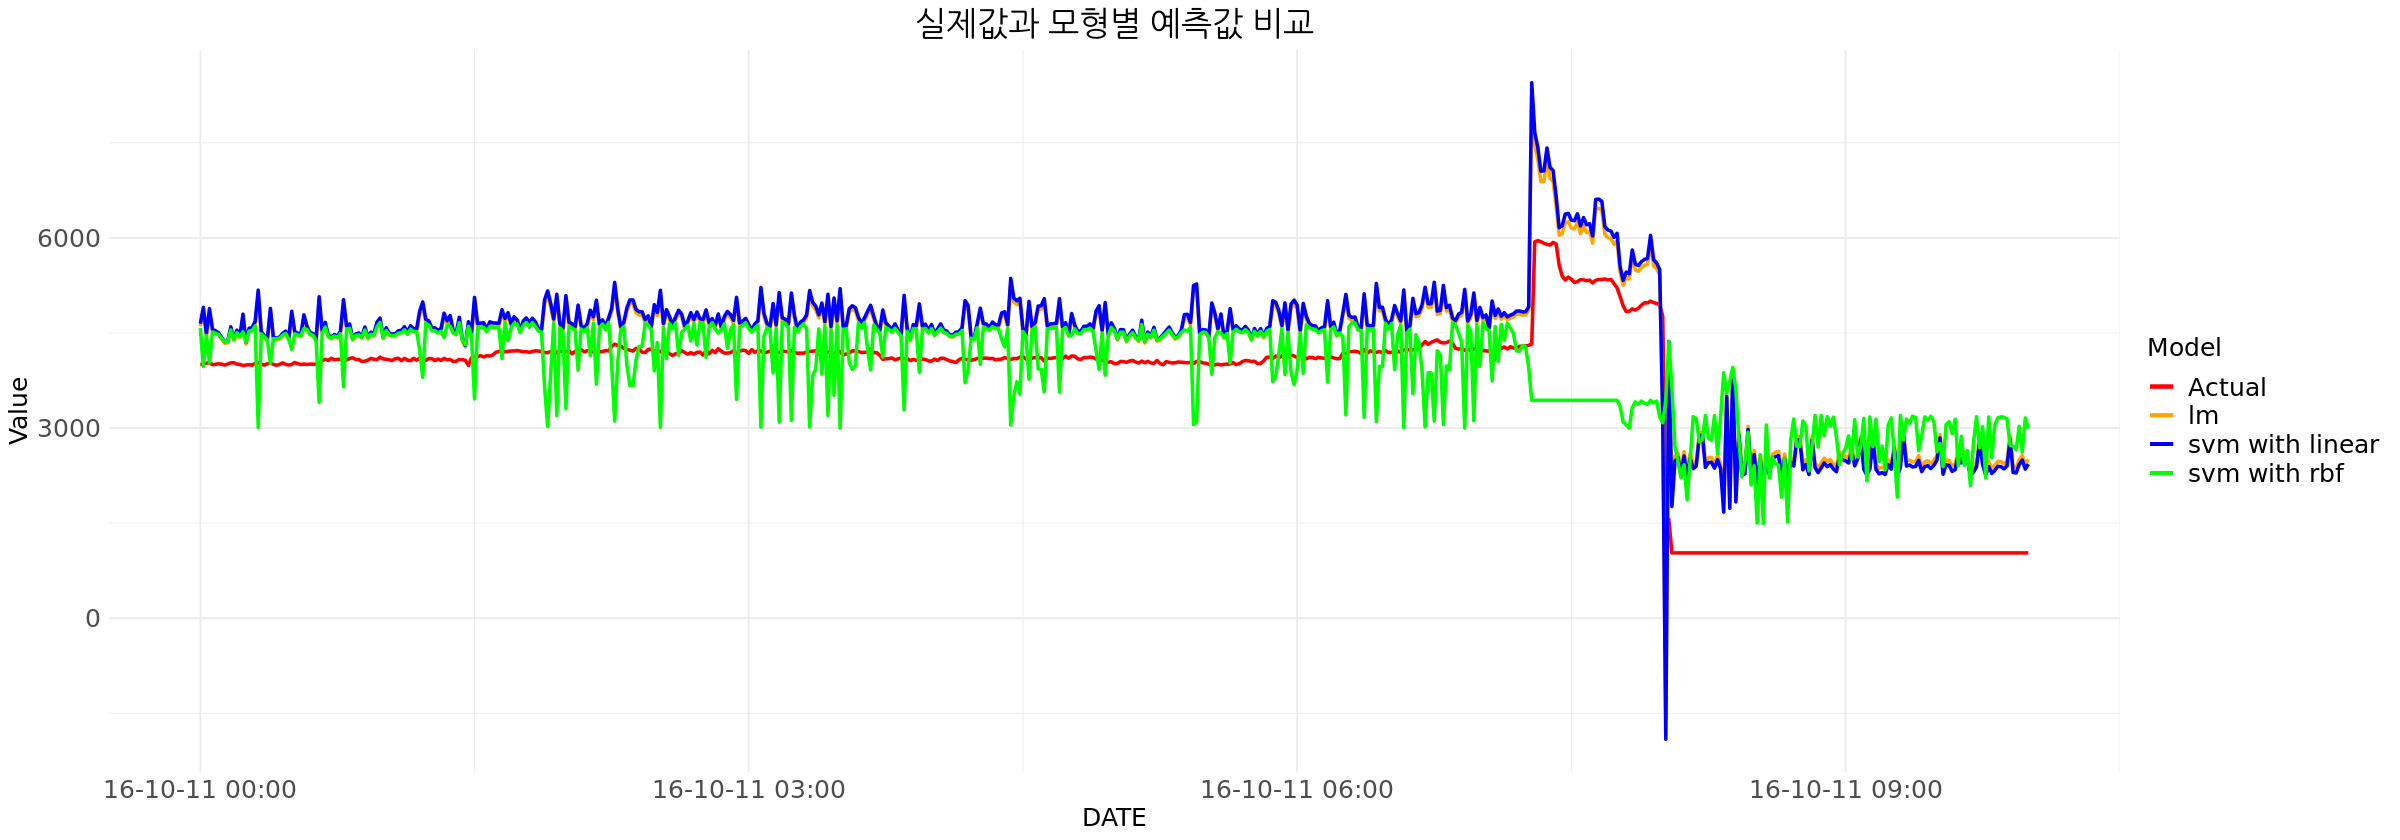

In [41]:
# 실제값과 모형별 예측값 비교(그래프)
options(repr.plot.width = 20, repr.plot.height = 7)

ggplot(result_df, aes(x = DATE)) +
    geom_line(aes(y = ACTUAL, color = 'Actual'), linewidth = 1) +
    geom_line(aes(y = LM, color = 'lm'), linewidth = 1) +
    geom_line(aes(y = SVM_LINEAR, color = 'svm with linear'), linewidth = 1) +
    geom_line(aes(y = SVM_RBF, color = 'svm with rbf'), linewidth = 1) + labs(color = 'Model') + 
    ylab('Value') + ggtitle('실제값과 모형별 예측값 비교') + theme_minimal() + 
    theme(plot.title = element_text(hjust = 0.5, size = 20), strip.text.x = element_text(size = 15), axis.title = element_text(size = 15), axis.text = element_text(size = 15), 
          legend.text = element_text(size = 15), legend.title = element_text(size = 15)) +
    scale_x_datetime(labels = date_format('%y-%m-%d %H:%M')) +
    scale_color_manual(values = c('Actual' = 'red', 'lm' = 'orange', 'svm with linear' = 'blue', 'svm with rbf' = 'green'),
                      limits = c('Actual', 'lm', 'svm with linear', 'svm with rbf'))

중부분기 지점의 실제 유량 측정값과 모형별 예측값을 그래프로 시각화하여 비교합니다.

# 학습포인트

* 광역상수도에서 취득한 시계열 데이터(유량 및 차압) 시각화
* 선형회귀, SVM(Support Vector Machine) 등 머신러닝 알고리즘을 활용한 유량 예측
* 유사 Mass Balance 분석을 활용한 광역상수도 누수 감지

# 레시피 정보

* 디지털 물산업 분야 학습용 예제 레시피 제작
* 생성일자: 2023년 05월 31일
* 사용언어: R
* Kwater 빅데이터콘테스트 발표연도 및 부서: 2017년 / 물에너지연구소